In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
input_file = 'SimpleTree.root'
events = ur.open("%s:data"%(input_file))
arrays = events.arrays()

posx = arrays['Cal_hit_posx']
posy = arrays['Cal_hit_posy']
posz = arrays['Cal_hit_posz']
energy = arrays['Cal_hit_energy']

adcsum = arrays['Cal_adcsum']
detid = arrays['Cal_detid']

cut_primary = arrays['Cal_hit_energy']>0
cut_HCAL = (arrays['Cal_hit_energy']>0) & ((arrays['Cal_detid']==2) ^ (arrays['Cal_detid']==3))
cut_ECAL = (arrays['Cal_hit_energy']>0) & ((arrays['Cal_detid']==0) ^ (arrays['Cal_detid']==1))

xcut = posx[cut_primary]
ycut = posy[cut_primary]
zcut = posz[cut_primary]
ecut = energy[cut_primary]

xHcal = posx[cut_HCAL]
yHcal = posy[cut_HCAL]
zHcal = posz[cut_HCAL]
eHcal = energy[cut_HCAL]

xEcal = posx[cut_ECAL]
yEcal = posy[cut_ECAL]
zEcal = posz[cut_ECAL]
eEcal = energy[cut_ECAL]

In [13]:
norms = np.sqrt(xcut**2 + ycut**2 + zcut**2)
px = (xcut / norms) * ecut
py = (ycut / norms) * ecut
pz = (zcut / norms) * ecut
ex = np.abs(px)

lorentz = {"px": px, "py": py, "pz": pz, "E": ecut}

allLorentz = ak.from_iter([lorentz])
print(allLorentz)

[{px: [[-0.074, ..., 0.0281], ...], py: [[...], ...], pz: [...], E: [...]}]


In [9]:
# Define the jet definition
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

# Cluster the particles into jets
cluster = fastjet.ClusterSequence(allLorentz, jetdef)
inc_jets = cluster.inclusive_jets()

# Define a function to calculate the x, y, and z components of the momentum vector
def momentum_xyz(px, py, pz):
    norm = np.sqrt(px**2 + py**2 + pz**2)
    x = px / norm
    y = py / norm
    z = pz / norm
    return x, y, z

# Define a function to calculate the eta coordinate
def eta(y, z):
    theta = abs(np.arctan(y / z))
    return -1 * np.log(np.tan(theta / 2))
def inverse_eta(eta, z):
    y = z * (2 * np.exp(-eta)) / (1 - np.exp(-2*eta))
    return y

In [10]:
# Mask the jets based on the energy of their constituents
mask = inc_jets.E > 5
inc_jets_masked = inc_jets[mask][0]

# Extract the x, y, and z components of the momentum vector
jetX, jetY, jetE = [], [], []
jetXAll, jetYAll, jetEAll, jetEta = [], [], [], []


x, y, z = momentum_xyz(inc_jets_masked.px, inc_jets_masked.py, inc_jets_masked.pz)
    
jetE = inc_jets_masked.E
jetXH = 806 * x / z
jetYH = 806 * y / z

jetXE = 724 * x / z
jetYE = 724 * y / z

jetEta = eta(y, z)

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


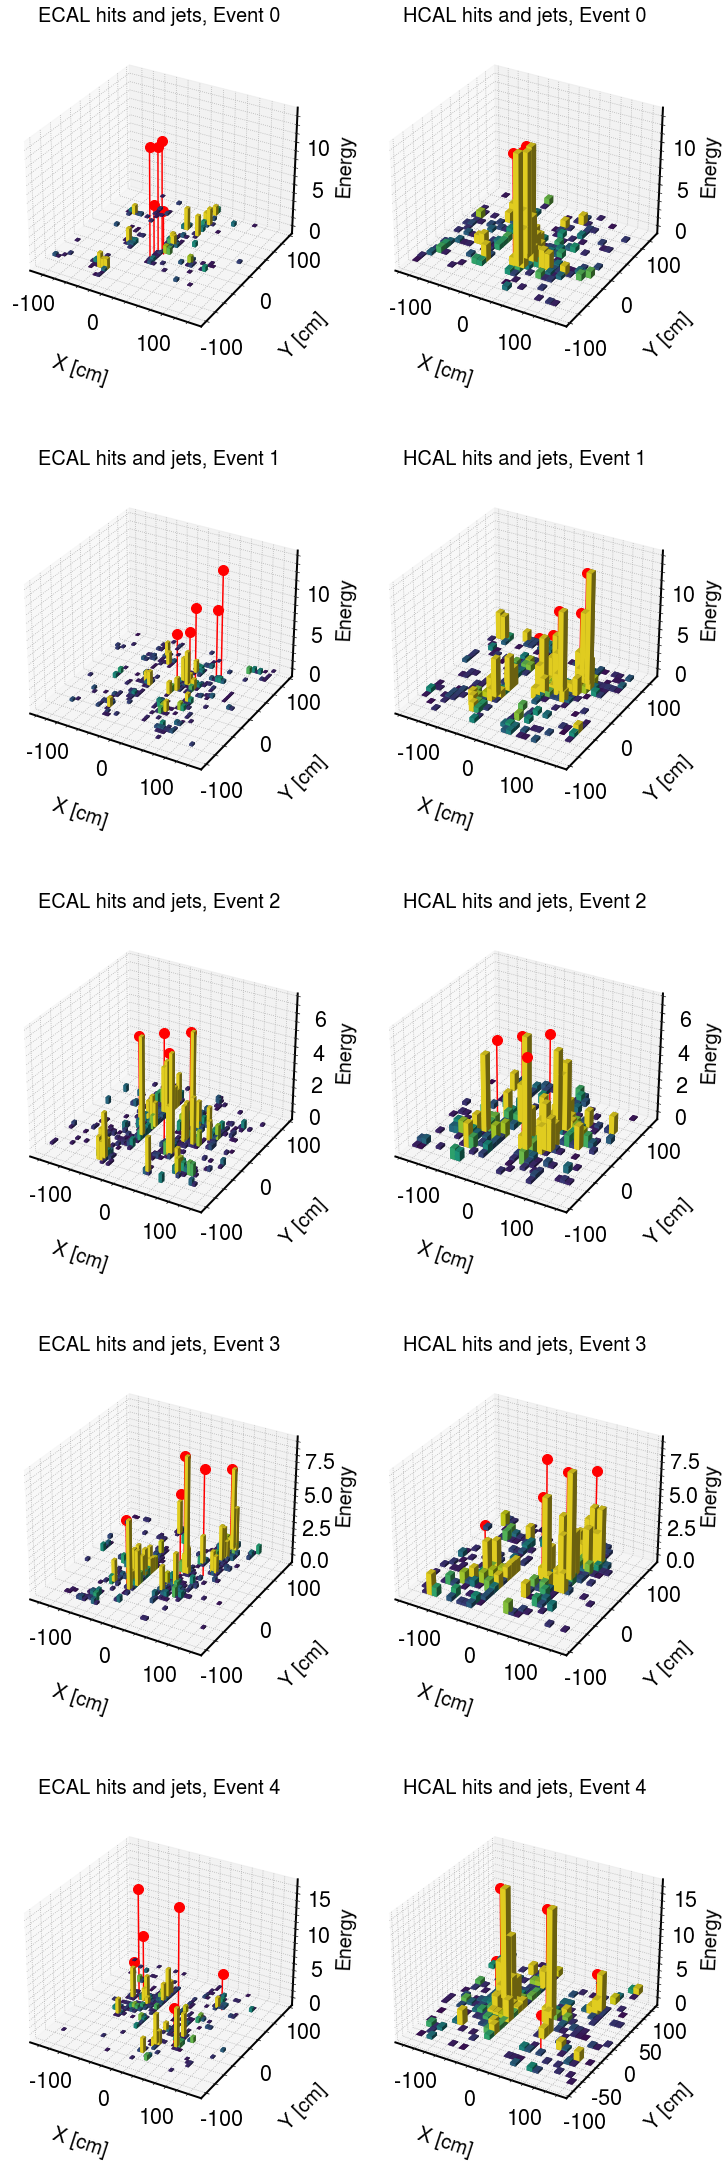

In [11]:
n = 5

fig, axs = plt.subplots(nrows=n, ncols=2, subplot_kw={'projection': '3d'}, figsize=(12, 8*n), gridspec_kw={'hspace': 0.1})

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')

for i in range(n):
    evt = i
    
    ax = axs[i][0]
    ax.set_title(f'ECAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.bar3d(np.array(xEcal[evt]), np.array(yEcal[evt]), 0, 5.5694733, 5.572006, np.array(eEcal[evt]), color=[cmap(k) for k in np.array(eEcal[evt])])

    plt.xlim(-150,150)
    plt.ylim(-100,100)
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXE[evt][j]
        y_pos = jetYE[evt][j]
        z_pos = jetE[evt][j]
        ax.scatter(x_pos, y_pos, z_pos, s=100, color='red', marker='o')
        ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, z_pos], color='red')
    
    
    ax = axs[i][1]
    ax.set_title(f'HCAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.bar3d(np.array(xHcal[evt]), np.array(yHcal[evt]), 0, 9.985443, 9.98999, np.array(eHcal[evt]), color=[cmap(k) for k in np.array(eHcal[evt])])

    plt.xlim(-150,150)
    plt.ylim(-100,100)
    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)
    ax.set_zlabel('Energy', fontsize=20)

    ax.yaxis.labelpad=30
    ax.xaxis.labelpad=30
    ax.zaxis.labelpad=10

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXH[evt][j]
        y_pos = jetYH[evt][j]
        z_pos = jetE[evt][j]
        ax.scatter(x_pos, y_pos, z_pos, s=100, color='red', marker='o')
        ax.plot([x_pos, x_pos], [y_pos, y_pos], [0, z_pos], color='red')

plt.tight_layout()



/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


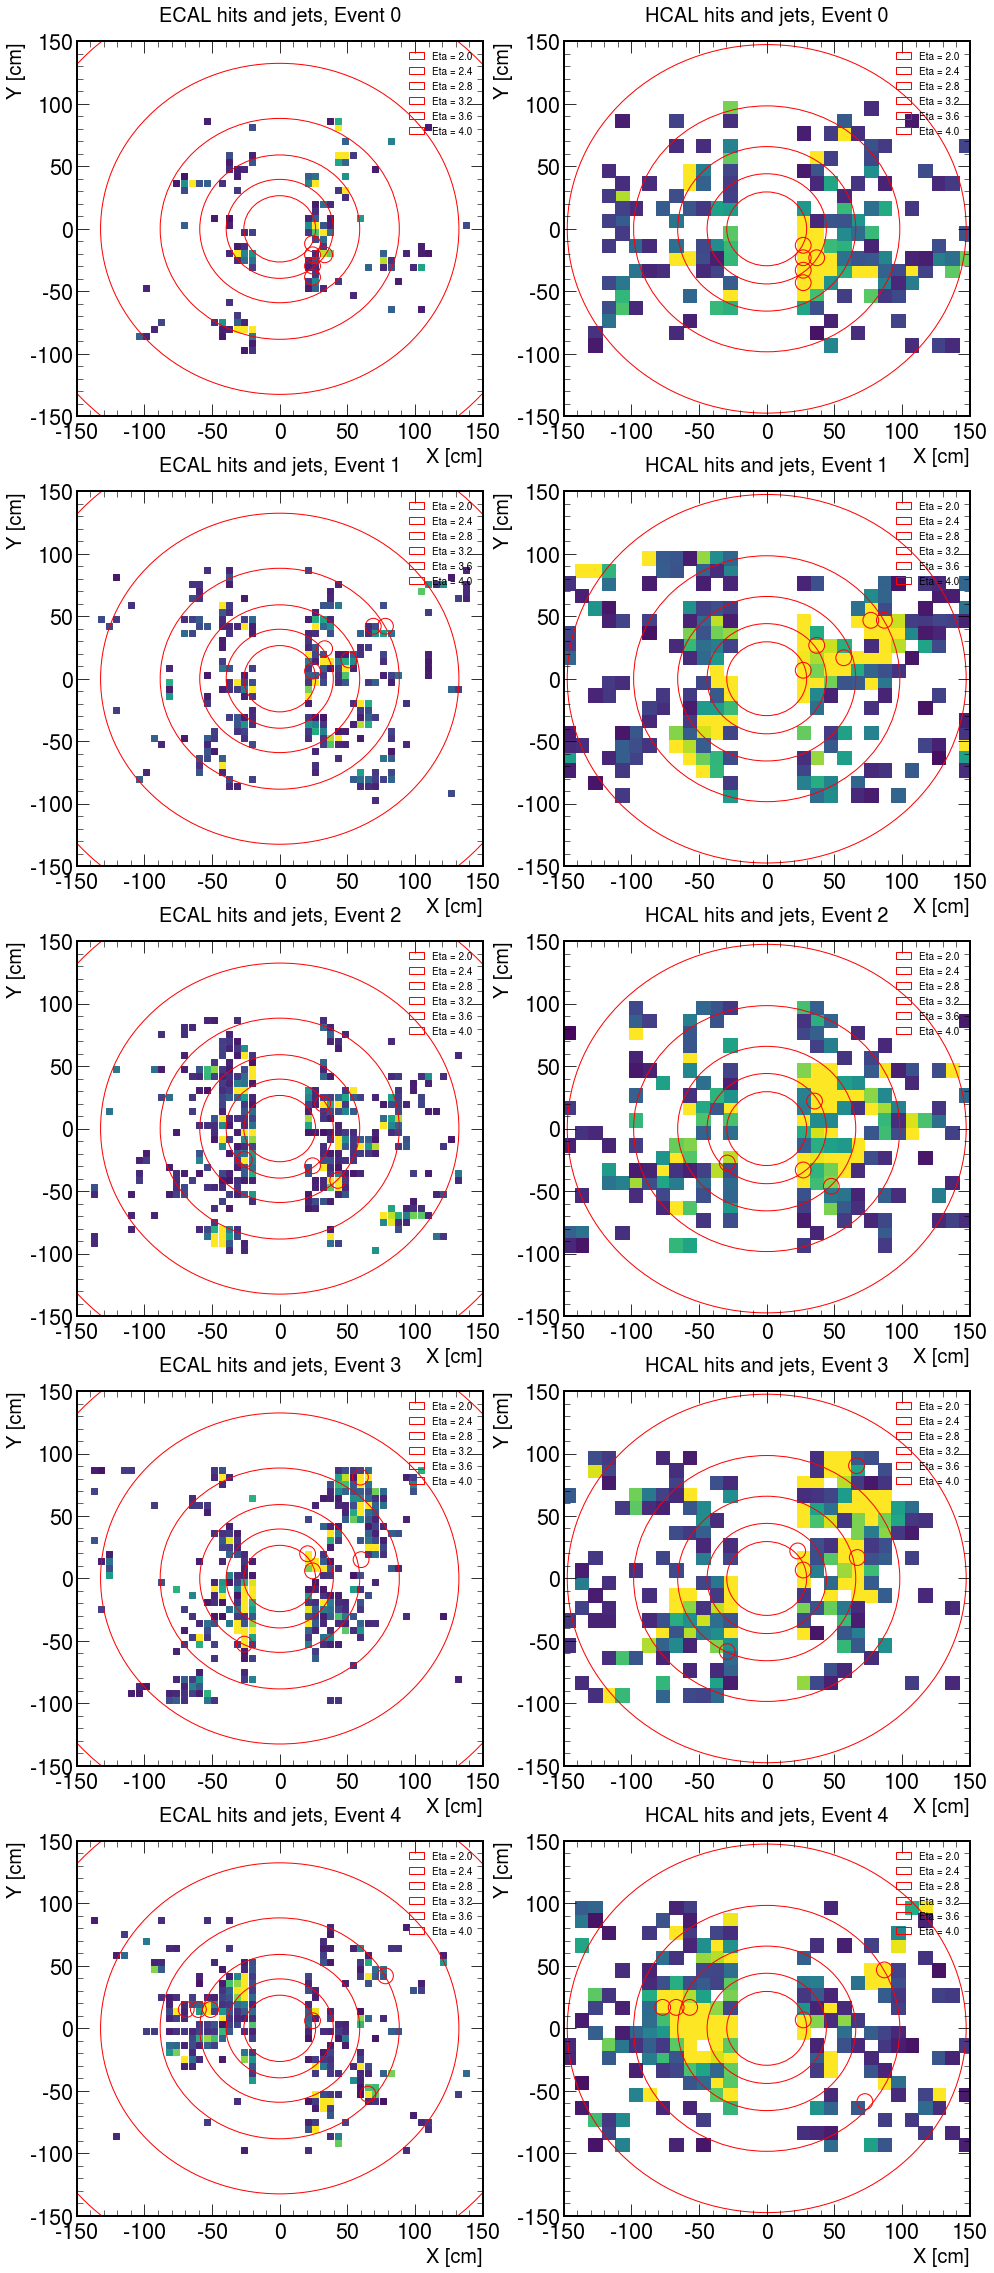

In [12]:
from matplotlib.patches import Circle

n = 5

fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(16, 8*n), gridspec_kw={'hspace': 0.2})

inferno = plt.get_cmap('viridis')
cmap = plt.get_cmap('viridis')

for i in range(n):
    evt = i
    
    ax = axs[i][0]
    ax.set_title(f'ECAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.scatter(np.array(xEcal[evt]), np.array(yEcal[evt]), marker = 's', color=[cmap(k) for k in np.array(eEcal[evt])])

    

    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)


    for j in range(20, 44, 4):
        j = j / 10.0
        R = inverse_eta(j,724)
        color = ((1 - (j-2))/2, 0, (j-2)/2)
        circle = Circle((0, 0), R, color='r', fill=False, label = f'Eta = {j}')
        axs[i,0].add_patch(circle)  
   
    handles, labels = axs[i,0].get_legend_handles_labels()

    
    axs[i,0].legend(handles, labels, loc='upper right',fontsize=10)
 
    axs[i,0].set_ylim(-150,150)
    axs[i,0].set_xlim(-150,150)
    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXE[evt][j]
        y_pos = jetYE[evt][j]

        ax.scatter(x_pos, y_pos, s=250, facecolors='none', edgecolors='r')

    
    
    ax = axs[i][1]
    ax.set_title(f'HCAL hits and jets, Event {evt}', fontsize=20, pad=20)
    ax.scatter(np.array(xHcal[evt]), np.array(yHcal[evt]), s=180, marker='s', color=[cmap(k) for k in np.array(eHcal[evt])])

    axs[i,1].set_ylim(-150,150)
    axs[i,1].set_xlim(-150,150)
    
    for j in range(20, 44, 4):
        j = j / 10.0
        R = inverse_eta(j,806)
        color = ((1 - (j-2))/2, 0, (j-2)/2)
        circle = Circle((0, 0), R, color='r', fill=False, label = f'Eta = {j}')
        axs[i,1].add_patch(circle) 
   
    handles, labels = axs[i,1].get_legend_handles_labels()

    axs[i,1].legend(handles, labels, loc='upper right', fontsize=10)

    ax.set_xlabel('X [cm]', fontsize=20)
    ax.set_ylabel('Y [cm]', fontsize=20)

    for j in range(len(np.array(jetE[evt]))):
        x_pos = jetXH[evt][j]
        y_pos = jetYH[evt][j]
        ax.scatter(x_pos, y_pos, s=250, facecolors='none', edgecolors='r')


plt.tight_layout()

